## Column Definitions

Data comes from: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* X2: Sex (1 = male; 2 = female).
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others).
* X5: Age (year).
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



## Import Libraries

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import eli5
import matplotlib.pyplot as plt
%matplotlib inline

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


# Read data and drop "duration" column since this column is collected after label is observed.
df = pd.read_csv(r'C:/Users/mzhang40/data/credit_card_default/UCI_Credit_Card.csv').drop(['ID'], axis=1)
df.EDUCATION = df.EDUCATION.map({1: 'gradSchool', 2: 'college', 3: 'hiSchool', 4: 'other'})
df.MARRIAGE = df.MARRIAGE.map({1: 'married', 2: 'single', 3: 'other'})
df.SEX = df.SEX.map({1: 'male', 2: 'female'})
df.rename(columns={'default.payment.next.month': 'y'}, inplace=True)
df.y = np.where(df.y == 1, 'yes', 'no');

## Feature Engineering

In [19]:
# Derive payment-to-bill ratios
df = pd.concat([
    df,
    pd.DataFrame(
        np.array(df.iloc[:, 17:23]) / np.array(df.iloc[:, 11:17]),
        columns=['PAY_BILL1', 'PAY_BILL2', 'PAY_BILL3', 'PAY_BILL4', 'PAY_BILL5', 'PAY_BILL6'],
    ).replace({np.nan: 1, np.inf: 1})

], axis=1)

# Derive credit utilities
df = pd.concat([
    df,
    pd.DataFrame(
        np.array(df.iloc[:, 11:17]) / np.array(df.LIMIT_BAL).reshape((30000, 1)),
        columns=['CREDIT_UTIL1', 'CREDIT_UTIL2', 'CREDIT_UTIL3', 'CREDIT_UTIL4', 'CREDIT_UTIL5', 'CREDIT_UTIL6']
    )
], axis=1)

<ipython-input-19-8974892fc490>:5: RuntimeWarning: divide by zero encountered in true_divide
  np.array(df.iloc[:, 17:23]) / np.array(df.iloc[:, 11:17]),
<ipython-input-19-8974892fc490>:5: RuntimeWarning: invalid value encountered in true_divide
  np.array(df.iloc[:, 17:23]) / np.array(df.iloc[:, 11:17]),


## Prepare Data For Modeling

In [20]:
# Create dummy variables and train/test split
df_dummy = pd.concat([pd.get_dummies(df.drop(['y'], axis=1)), df.y], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop(['y'], axis=1), df_dummy.y, test_size=0.3, random_state=1)

## Feature Distributions

Looks like the derived features: Credit Utilities have strong tendency to seperate the two classes.

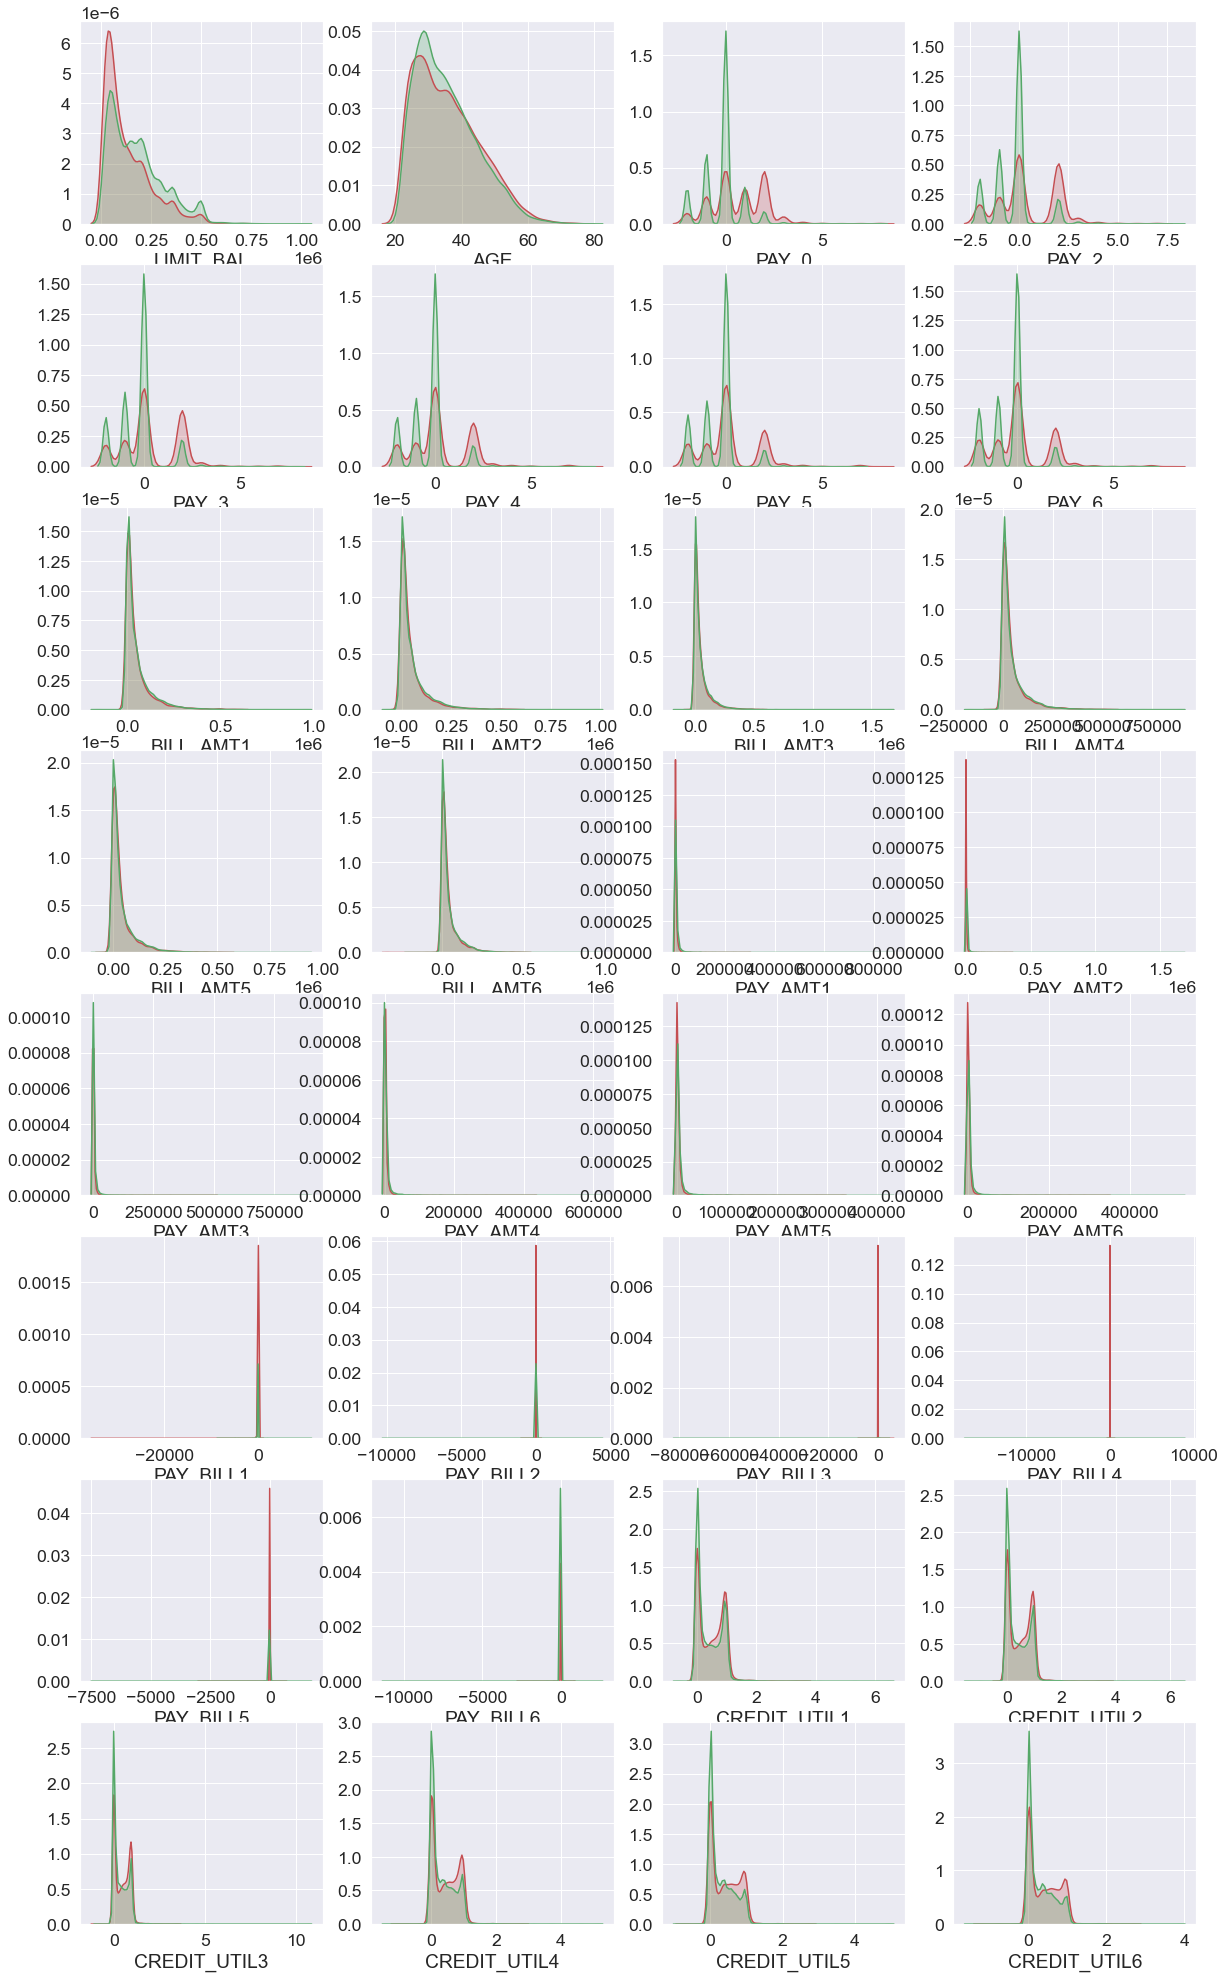

In [21]:
df_num = df.select_dtypes(exclude='object')
fig, axes = plt.subplots(8, 4, figsize=(20, 35))
idx = 0

sns.set(font_scale=1.3)
for i in range(0, 8):
    for j in range(0, 4):
        sns.distplot(df_num.iloc[:, idx][df.y == 'yes'], hist=False, kde_kws={"shade": True}, ax=axes[i, j], color='r')
        sns.distplot(df_num.iloc[:, idx][df.y == 'no'], hist=False, kde_kws={"shade": True}, ax=axes[i, j], color='g')
        if idx == 31:
            break
        else: idx += 1

## Fit Models

In [22]:
seed = 1

rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(random_state=seed)
gb_model.fit(X_train, y_train)

tree_model = DecisionTreeClassifier(random_state=seed)
tree_model.fit(X_train, y_train)

logit_model = LogisticRegression(max_iter=2000, random_state=seed)
logit_model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=1)

## Correlation Heatmap

This section visually inspects correlation between numeric features. Strong correlation will violate assumption of some models such as linear regression.

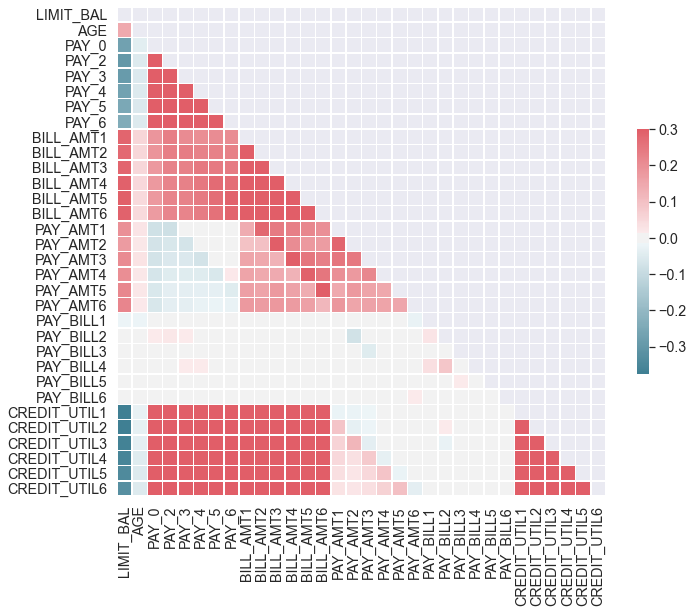

In [23]:
mask = np.triu(np.ones_like(df_num.corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_num.corr(), mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5});

## Feature Importance by Random Forest and Gradient Boosting

This section we let models tell us what features are important.

Taking top five features from each model, here's the result:
Age, euribor3m, campaign, pdays, nr.employed, and cons.conf.idx.

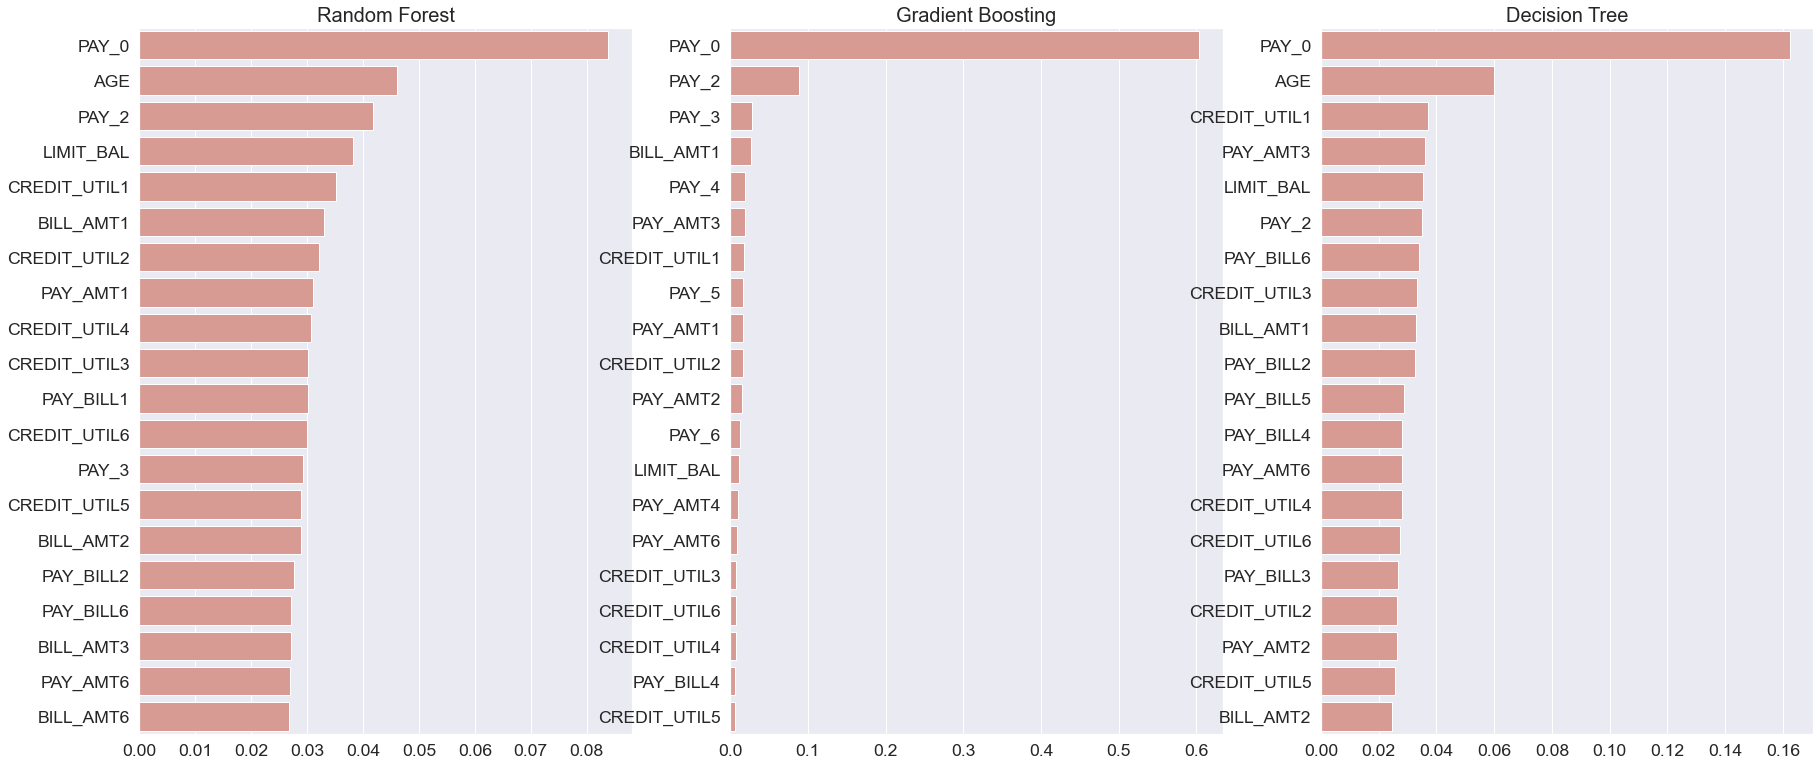

In [24]:
def featureImp(model, trainSet, top_n=20, ax=0):
    feature_imp = pd.Series(data=model.feature_importances_, index=trainSet.columns).sort_values(ascending=False)[:top_n]
    sns.barplot(feature_imp.values, feature_imp.index, ax=ax, color='salmon', saturation=0.5)
    
def permutationImp(model, X_test, y_test):
    perm = PermutationImportance(model, random_state=seed).fit(X_test, y_test)
    return eli5.show_weights(perm, feature_names=X_test.columns.tolist())

sns.set(font_scale=1.6)
fig, axes = plt.subplots(1, 3, figsize=(30, 13))
featureImp(rf_model, X_train, ax=axes[0])
featureImp(gb_model, X_train, ax=axes[1])
featureImp(tree_model, X_train, ax=axes[2])
axes[0].set_title('Random Forest', fontsize=20)
axes[1].set_title('Gradient Boosting', fontsize=20)
axes[2].set_title('Decision Tree', fontsize=20);

## Permutation Importance by Random Forest

Taking top five from each model, here's the result:
pdays, month_oct, month_apr, poutcome_failure, poutcome_success, nr.employed, euribor3m, emp.var.rate, and cons.price.idx.

month_oct and month_apr are pretty interesting... Maybe part of the consumers that this bank is targeting are seasonal workers so that their income are high in these 2 months?

In [25]:
permutationImp(rf_model, X_test, y_test)

Weight,Feature
0.0516 ± 0.0032,PAY_0
0.0008 ± 0.0013,PAY_2
0.0005 ± 0.0012,BILL_AMT5
0.0004 ± 0.0008,PAY_BILL2
0.0004 ± 0.0013,PAY_AMT4
0.0004 ± 0.0010,PAY_AMT2
0.0003 ± 0.0019,AGE
0.0003 ± 0.0017,EDUCATION_college
0.0003 ± 0.0023,LIMIT_BAL
0.0003 ± 0.0016,PAY_AMT5


## Permutation Importance by Gradient Boosting

In [26]:
permutationImp(gb_model, X_test, y_test)

Weight,Feature
0.0671 ± 0.0040,PAY_0
0.0018 ± 0.0007,CREDIT_UTIL1
0.0011 ± 0.0008,PAY_5
0.0011 ± 0.0010,PAY_6
0.0011 ± 0.0012,PAY_BILL4
0.0009 ± 0.0010,PAY_2
0.0007 ± 0.0007,CREDIT_UTIL3
0.0006 ± 0.0007,BILL_AMT4
0.0006 ± 0.0008,PAY_3
0.0005 ± 0.0003,BILL_AMT6


## Permutation Importance by Logistic Regression

In [27]:
permutationImp(logit_model, X_test, y_test)

Weight,Feature
0.0234 ± 0.0025,BILL_AMT1
0.0135 ± 0.0018,BILL_AMT2
0.0010 ± 0.0001,PAY_AMT1
0.0007 ± 0.0011,BILL_AMT5
0.0001 ± 0.0001,PAY_AMT2
0.0001 ± 0.0002,BILL_AMT3
0.0000 ± 0.0007,BILL_AMT4
0.0000 ± 0.0001,PAY_BILL2
0 ± 0.0000,PAY_AMT4
0 ± 0.0000,PAY_4
